# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

# Predicting Popularity of Playlists Using Spotify Data
**Harvard University**<br/>
**Fall 2021**<br/>
**Group members**: Ilona Demler, Daniela Garcia, Kayla Manning, Saul Soto

<hr style="height:2pt">

**Abstract**: Thousands of playlists are created per day on Spotify by people looking to store their favorite songs into one location. While most playlists tend to go unnoticed by a majority of users, there are a few that blow up in popularity. What determines what makes a playlist popular? We look at pre-processed data from a million playlists collected by Spotify from 2010-2017 and perform linear, decision tree, bagging, and boosting regression to predict the number of followers a playlist will have. While one model did perform slightly better in the end, we found that in general all of our models did not predict follower count well due to limitations in the data we were using.

<hr style="height:2pt">

## Introduction
This project utilizes the <a href='https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/dataset_files'>Million Playlist Dataset</a>, which consists of a sample of 1 million public playlists from over 4 billion public playlists on Spotify. Consisting of over 2 million unique tracks from nearly 300,000 artists, the dataset contains public playlists created by Spotify users between January 2010 and October 2017. 

The dataset, sourced from <a href='https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge'>AIcrowd</a>, contains information about the names of the playlists, the playlist IDs, playlist duration, the tracks in the playlist, and other playlist statistics. The playlists are anonymized to protect user information, and have some fake songs to add noise to the data. Thus, the playlists in this dataset are not a representation of all the playlists on Spotify.

We used this dataset to find out what feature(s) of a playlist impact its popularity. After removing predictors that we did not relevant to answering this question (playlist ID, track ID, etc.), we were left with the following variables:
* popular_name - binary, indicating if name is in most popular names
* has_description - binary, indicating if description is present
* num_artists 
* num_albums
* num_tracks 
* duration_ms - duration of playlist (not to be confused with track duration, same name)
* collaborative: binary, indicates if playlist is collaborative
* popular_track - binary, indicates if track_name in list of most popular tracks
* popular_artist - binary, indicates if artist_name is in most popular artists
* total_popular_tracks - sum of popular_track
* total_popular_artists - sum of popular_artist
* num_followers: response variable


## Import Libraries



In [28]:
# import standard libraries
import os
import pandas as pd
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import itertools
import math
import missingno as msno
import re
import requests
from bs4 import BeautifulSoup
from collections import Counter

# import model tools
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# import viz libraries
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

## Converting the Data from .json to .csv



The following code has been commented out, as this data conversion was done only once to generate 1000 .csv files from 1000 .json files. 

The original .json files can be found here:

https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/dataset_files

The converted .csv files can be found here:

https://drive.google.com/drive/folders/1v9VchFigNE4bWx8jpaLzMrUlzH9zCQu9?usp=sharing

In [29]:
# get file names
# file_names = os.listdir('/Users/danielagarcia/OneDrive - Harvard University/Sophomore Year/CS109a/jupyter/final_project_data/spotify_million_playlist_dataset/data')
# assert len(file_names) == 1000

# iterate through each json and convert
# for file in file_names:
    # read file
#     data = json.load(open(file))
#     df_temp = pd.DataFrame(data["playlists"])
    
    # make csv file name and save
#     new_name = file.replace('.json', '.csv')
#     df_temp.to_csv('/Users/danielagarcia/OneDrive - Harvard University/Sophomore Year/CS109a/jupyter/cs109a-final-project/Data/data/' + new_name)

## Joining the .csv Files into One Dataframe



The following code has been commented out, as this data joining was done only once to generate one final data frame of 1M observations.

The entire aggregate data frame can be found here:

https://drive.google.com/file/d/11kJ_E_K5ekkaN5SuYU5sjKqgR8uSMuxA/view?usp=sharing

In [30]:
# initialize path to files
# path_stem = "/Users/danielagarcia/OneDrive - Harvard University/Sophomore Year/CS109a/jupyter/cs109a-final-project/Data/data/"
# file_names = os.listdir(path_stem)

# create empty data frame to store concatenated slices
# playlist_data_raw = pd.DataFrame()

# combine each slice into one data frame 
# for file in file_names:
#     data_temp = pd.read_csv(path_stem + file)
#     playlist_data_raw = playlist_data_raw.append(data_temp, ignore_index = True)    

## Sampling the Aggregate Data



The following code has been commented out, as this data sampling was done only once to generate a final sample data frame of 100K observations used in our analysis.

The final sampled data frame can be found here: 

https://drive.google.com/file/d/1ZCZ_zToKo0_gw1TLZAnL-LP_QSijSstm/view?usp=sharing

In [31]:
# sample data 
# data_sample = playlist_data_raw.sample(100000, random_state = 109, ignore_index = True)
# playlist_data_sample = data_sample[[c for c in data_sample.columns if 'Unnamed' not in c]]

## Loading the Data Sample



In [32]:
# initialize file path
#data_sample_file_100K = "/Users/danielagarcia/OneDrive - Harvard University/Sophomore Year/CS109a/jupyter/cs109a-final-project/Data/data_sample_100K.csv"
#data_sample_file_100K = "/Users/ilonademler/Documents/Harvard/Junior_fall/cs_109/final_project/cs109a-final-project/Data/data_sample_100K.csv"
# data_sample_file_100K = "/Users/kaylamanning/Downloads/data_sample_100K.csv"
data_sample_file_100K = "/Users/saul/CS109A/2021-CS109A/project/cs109-personal-notebook/data_sample_100K.csv"

# load sampled data
data_sam = pd.read_csv(data_sample_file_100K)
playlist_data_sample = data_sam[[c for c in data_sam.columns if 'Unnamed' not in c]]

## Get Audio Features from Spotipy API



The Spotify API is a powerful tool that allows us to access all of the information that Spotify has. This includes audio features, audio analysis (more specific information about the track like its tempo and when it starts), and more. By using the `Spotipy` module in python, we are able to provide it with our credentials to get access to even more predictors that can help us improve our model's performance and accuracy. For our projects, the audio features we were looking at were (definitions from https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features):
* danceability: Suitability of a track for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. 0.0 is least danceable, 1.0 is very danceable
* energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Energetic tracks feel fast, and loud/noisy
* valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

The following code was not able to be used in our data analysis, as this API querying took much longer than expected, and we ended up not using the variables in our analysis. However, we still sought to include it to demonstrate our attempt to extract audio features from each track in every playlist. We provide a brief demo with using the spotify audio features to visualize data for 50 playlists at the end of the notebook.

**Expected runtime:** 20 hours for 10k playlists, 8-10 days to render data for 100k playlists

In [33]:
def spotify_demo(playlist_info, client_id, client_secret):
    """
    This function provides a brief demo with using the Spotipy module to extract audio features from the Spotify API. 
    The audio features extracted from the tracks passed into the function are danceability, valence, and energy. More
    information on these audio features can be found at: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

    :param playlist_info: list, tracks contained in a playlist
    :param client_id: str, Spotify client id for authorization
    :param client_secret: str, Spotify secret key for authorization

    More information on Spotify credentials can be found here: https://developer.spotify.com/documentation/general/guides/authorization/client-credentials/

    :returns: playlist_df dataframe containing total danceability, valence, and energy as well as average danceability, valence,
              and energy per playlist

    """

    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials

    spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))
    

    # Create empty playlist to store audio features information
    playlist_data = ['danceability', 'energy', 'valence', 'avg danceability', 'avg energy', 'avg valence']

    # initialize audio features data
    all_tracks_info = {}

    # storing features 
    total_danceability = []
    total_energy = []
    total_valence = []

    # get average audio features
    avg_danceability = []
    avg_energy = []
    avg_valence = []


    # Loop through each playlist to extract information
    for playlist in playlist_info:
        
        # Convert playlist info to string to prevent formatting errors
        playlist = eval(playlist)
        danceability = []
        energy = []
        valence = []
        
        for tracks in playlist:
            # Extract track ID 
            track_uri = tracks['track_uri']

            # Get audio features if track ID hasn't been requested
            if track_uri not in all_tracks_info:
                try:
                    audio_features = spotify.audio_features(track_uri)[0]
                except:
                    print('Timeout... trying again')
                    audio_features = spotify.audio_features(track_uri)[0]

                

                # catching Nonetype errors
                try:
                    danceability.append(audio_features['danceability'])
                    energy.append(audio_features['energy'])
                    valence.append(audio_features['valence'])
                except:
                    pass

            # Get track features from dict if it's already been seen (to prevent repetitive requests)
            else:
                track_feats = all_tracks_info[track_uri]

                danceability.append(track_feats['danceability'])
                energy.append(track_feats['energy'])
                valence.append(track_feats['valence'])
        
        # compute sum of audio features       
        total_danceability.append(sum(danceability))
        total_energy.append(sum(energy))
        total_valence.append(sum(valence))

        # compute average values of audio features per track
        avg_danceability.append(np.mean(danceability))
        avg_energy.append(np.mean(energy))
        avg_valence.append(np.mean(valence))

    # Zip all of the track info lists together
    playlist_features = zip(total_danceability, total_energy, total_valence, avg_danceability, avg_energy, avg_valence)

    #Create dataframe for features and concat it with empty playlist
    playlist_df = pd.DataFrame(playlist_features, columns=playlist_data)

    return playlist_df

## Cleaning the Data



The following code cleans our sampled data frame and generates new predictors of interest.

In [34]:
# clean data

# initialize popular names, artists, songs
popular_names = ["country", "chill", "rap", "workout", "oldies", "christmas", "rock", "party", "throwback", 
                 "jams", "worship", "summer", "feels", "new", "disney", "lit", "throwbacks", "music", "sleep", "vibes"]

popular_artists = ["Drake", "Kanye West", "Kendrick Lamar", "Rihanna", "The Weeknd", "Eminem", "Ed Sheeran", "Future", 
                   "Justin Bieber", "J. Cole", "Beyoncé", "The Chainsmokers", "Chris Brown", "Calvin Harris", 
                   "Twenty One Pilots", "Lil Uzi Vert", "Post Malone", "Big Sean", "Maroon 5", "JAY Z"]

popular_tracks = ["HUMBLE. by Kendrick Lamar", "One Dance by Drake", "Broccoli (feat. Lil Yachty) by DRAM", 
                  "Closer by The Chainsmokers", "Congratulations by Post Malone", "Caroline by Aminé", 
                  "iSpy (feat. Lil Yachty) by KYLE", "Bad and Boujee (feat. Lil Uzi Vert) by Migos", "Location by Khalid",
                  "XO TOUR Llif3 by Lil Uzi Vert", "Bounce Back by Big Sean", "Ignition - Remix by R. Kelly", 
                  "No Role Modelz by J. Cole", "Mask Off by Future", "No Problem (feat. Lil Wayne & 2 Chainz) by Chance The Rapper",
                  "I'm the One by DJ Khaled", "Jumpman by Drake", "goosebumps by Travis Scott", "Fake Love by Drake",
                  "Despacito - Remix by Luis Fonsi"]

# extract predictor variables that don't need cleaning
playlist_data = playlist_data_sample[["num_tracks", "num_albums", "num_followers", "duration_ms", "num_artists"]].copy()

# initialize binary variables
playlist_data[["collaborative"]] = np.where(playlist_data_sample[["collaborative"]] == True, 1, 0)
playlist_data[["has_description"]] = np.where(playlist_data_sample[["description"]].isna(), 0, 1)

# create popular_name variable
popular_name = []
for playlist_name in playlist_data_sample["name"]:
    ## cast NaN values as strings
    if not isinstance(playlist_name, str):
        playlist_name = str(playlist_name)
    popular_name.append(np.where(any([name in playlist_name.lower() for name in popular_names]), 1, 0))
playlist_data[["popular_name"]] = pd.DataFrame(popular_name)

# extract track information
total_popular_tracks = []
total_popular_artists = []
playlist_tracks = playlist_data_sample["tracks"]

# iterate through each playlist
for track_data in playlist_tracks:
    # convert string to code
    track_data = eval(track_data)
    
    # initialize empty data frames to store data for each song in playlist
    pop_tracks = []
    pop_artists = []
    
    # iterate through each song in playlist
    for track_dict in track_data:
        track_name = track_dict["track_name"]
        artist_name = track_dict["artist_name"]
        
        # check if track name is popular
        if track_name + " by " + artist_name in popular_tracks:
            pop_tracks.append(1)
        else:
            pop_tracks.append(0)
        
        # check if artist name is popular
        if artist_name in popular_artists:
            pop_artists.append(1)
        else:
            pop_artists.append(0)
        
    
    # compute sum of popular songs and artists for that playlist
    total_popular_tracks.append(sum(pop_tracks))
    total_popular_artists.append(sum(pop_artists))

# add sums as new columns in data frame  
playlist_data[["total_popular_tracks"]] = pd.DataFrame(total_popular_tracks)
playlist_data[["total_popular_artists"]] = pd.DataFrame(total_popular_artists)


## Generating Train and Test Sets



For our train and test sets, we used an 80-20% split (as commonly used in class).

In [35]:
# split data into training and test data
X_data = playlist_data[["popular_name", "has_description", "num_artists", "num_albums", "num_tracks", 
                        "duration_ms", "collaborative", "total_popular_tracks", "total_popular_artists"]].copy()
y_data = playlist_data["num_followers"].copy()

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_data, y_data, train_size = 0.8, random_state = 109)

## Exploratory Data Analysis



### Filter Outcome Variable and Plot Histograms:

To generate more meaningful results, we want to filter out playlists with very few followers, since there is an overwhelming amount of them in the dataset.

In [36]:
# compute sums of numbers of followers to determine filtering threshold
count_y_train = dict(Counter(y_train_orig))
pd.DataFrame(zip(count_y_train.keys(), count_y_train.values()), columns = ["Value", "Count"]).sort_values("Value")

,Value,Count
1,1,60416
0,2,11862
3,3,3763
2,4,1543
4,5,749
...,...,...
132,6337,1
55,7912,1
62,7973,1
95,10911,1


**Interpretation**

Based on these counts, the data is clearly right-skewed. To build more meaningful models and results, we will filter out playlists with 2 followers or fewer. 

Total number of train and test observations: 7722 and 1997, respectively.



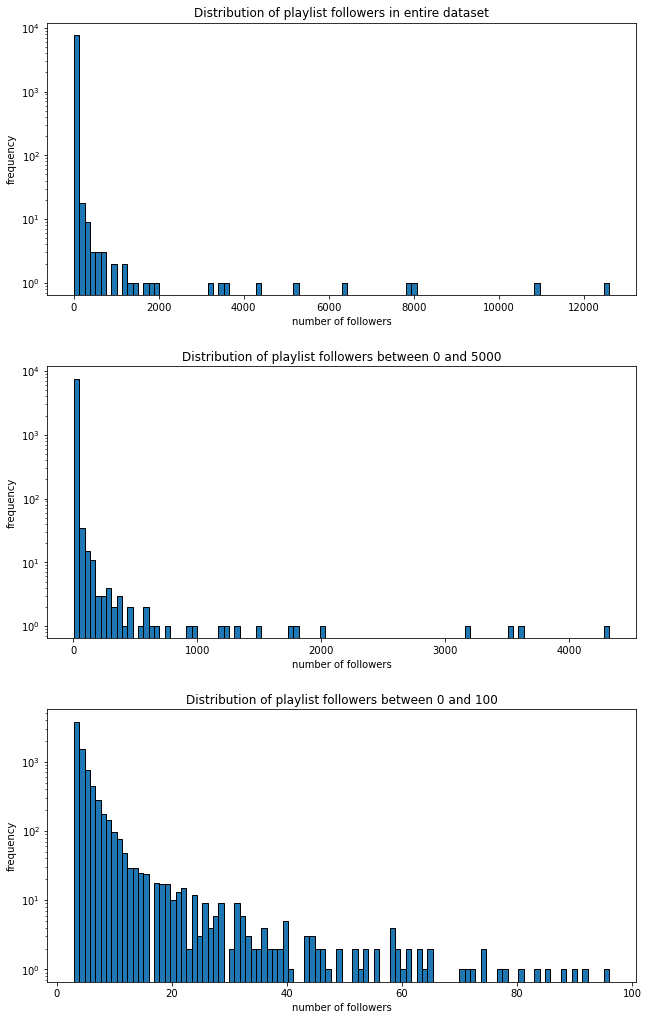

In [37]:
# filter outcome variable
train_ind = y_train_orig > 2
test_ind = y_test_orig > 2
X_train = X_train_orig[train_ind.values]
y_train = y_train_orig[train_ind]
X_test = X_test_orig[test_ind.values]
y_test = y_test_orig[test_ind]

print(f"Total number of train and test observations: {len(y_train)} and {len(y_test)}, respectively.\n")

# plot histograms of outcome variable
fig, ax = plt.subplots(3, 1, figsize = (10,15))
fig.tight_layout(pad = 5)

ax[0].hist(y_train, edgecolor = 'black', bins=100)
ax[0].set_yscale("log")
ax[0].set_title("Distribution of playlist followers in entire dataset")
ax[0].set_xlabel("number of followers")
ax[0].set_ylabel("frequency")

ax[1].hist(y_train[y_train<5000], edgecolor = 'black', bins=100)
ax[1].set_yscale("log")
ax[1].set_title("Distribution of playlist followers between 0 and 5000")
ax[1].set_xlabel("number of followers")
ax[1].set_ylabel("frequency")

ax[2].hist(y_train[y_train<100], edgecolor = 'black', bins=100)
ax[2].set_yscale("log")
ax[2].set_title("Distribution of playlist followers between 0 and 100")
ax[2].set_xlabel("number of followers")
ax[2].set_ylabel("frequency");


**Interpretation**

Based on these histograms, it looks like the data is very right-skewed and largely falls into either under or over 20 followers.

We considered translating `num_followers` into a binary categorical variable with a **threshold of 20**, with playlists with 20+ followers being considered "popular". However, due to the sheer number of playlists with a low number of followers, we will stick with regression.

### Collinearity Between Predictors

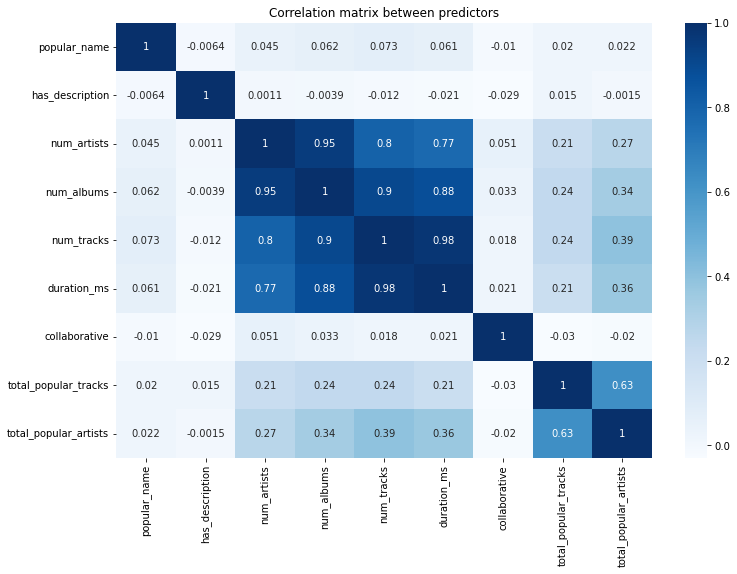

In [38]:
plt.figure(figsize=(12,8))
corr = X_train.corr()
sns.heatmap(corr, annot=True, cmap='Blues').set_title('Correlation matrix between predictors');

From the correlation matrix, we can denote 6 strong relationships between variables:
* **num_tracks** and **duration_ms** (0.98)  
* **num_albums** and **num_artists** (0.95)
* **num_albums** and **num_tracks** (0.9)
* **duration_ms** and **num_albums** (0.88)
* **num_tracks** and **num_artists** (0.8)
* **duration_ms** and **num_artists** (0.77)


Another way to check collinearity between predictors is to do variance inflation factor (VIF), which checks for the variance in the regression coefficients. VIF performs a regression on one predictor against all the others, which allows it to find predictors with high variance due to collinearity. The higher the VIF value, the more likely the predictor is highly correlated with another and will affect our regression results.

In [39]:
# Source: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
vif = pd.DataFrame(X_train.columns, columns=['predictor'])
vif['variance'] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

vif

,predictor,variance
0,popular_name,1.292884
1,has_description,1.034527
2,num_artists,38.591082
3,num_albums,77.719841
4,num_tracks,89.748475
5,duration_ms,69.308777
6,collaborative,1.032673
7,total_popular_tracks,1.996102
8,total_popular_artists,2.491911


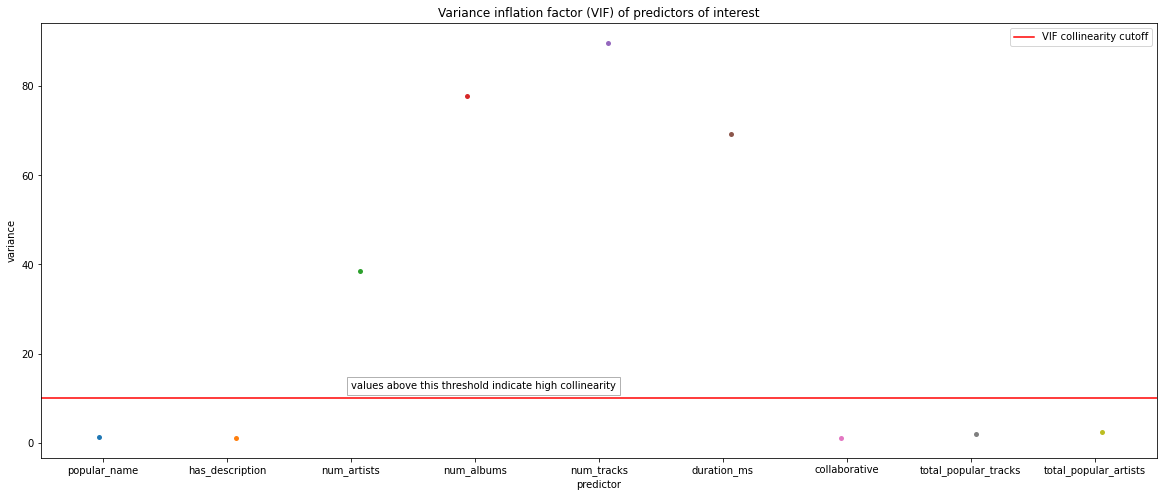

In [40]:
# Plotting the distribution of variances 
plt.figure(figsize=(20,8))
vif_dist = sns.stripplot(data=vif, x='predictor', y='variance')
vif_dist.axhline(y=10, color='r', label='VIF collinearity cutoff')
vif_dist.set_title('Variance inflation factor (VIF) of predictors of interest')
vif_dist.text(x=2, y=12, s='values above this threshold indicate high collinearity', bbox=dict(facecolor='white', alpha=0.3))
plt.legend()
plt.show()

As you can tell from the table and the scatter plot, there are four predictors that have an inflated variance when regressed on other variables. These are the same four predictors that the correlation matrix identified as having high correlatations with other variables, and the predictors with the highest correlation between other variables in ascending order is:
* **num_artists**
* **num_albums**
* **duration_ms**
* **num_tracks**

A lot of the correlation between the predictors make sense, as the more tracks you have the longer your playlist will be. Furthermore, since the number of albums and number of artists are not highly correlated with one another, we should expect to see that there are multiple albums coming from the same artist (or vice versa) in some of the playlists. When we go on to perform our regression, we will have to consider the relationship between these four predictors as they can skew our results to the extreme.

### Plot response variable vs. predictors

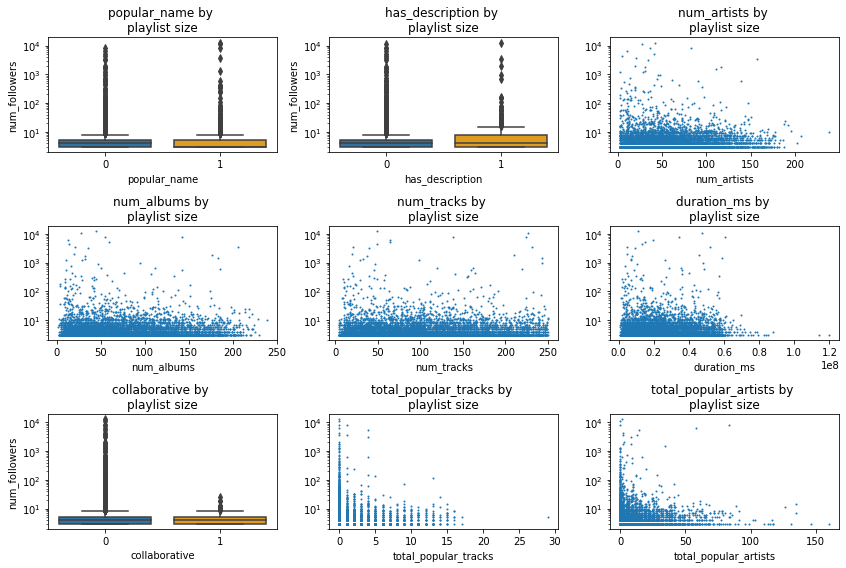

In [41]:
# will have to plot continuous and discrete variables differently
cat_vars = ["popular_name", "has_description", "collaborative"]
col_names = list(X_train.columns)

# creating whole training set so I can group by y_train_cat and do normalized plots with 
# percentages rather than counts
train = X_train.copy()
train['num_followers'] = y_train

# looping through and doing subplots
fig, ax = plt.subplots(3,3, figsize=(12,8))
for i in range(len(col_names)):
    
    # using this so I can assign the plots to the proper axes
    col = i%3
    row = int((i - i%3)/3)
    
    if col_names[i] in cat_vars:
        # want a boxplot for discrete variables, stratified by outcome
        sns.boxplot(x = col_names[i], y = 'num_followers', data = train, ax = ax[row,col],
                   palette = ['C0', 'orange'])
        
    else:
        # doing a histograms for continuous, filling for the category
        # getting normalized values for the counts
        ax[row,col].scatter(x = col_names[i], y = 'num_followers', data = train, s = 1)
        
    # formatting the plots with appropriate labels
    ax[row,col].set_xlabel(col_names[i])
    ax[row,col].set_title(f'{col_names[i]} by \nplaylist size')
    ax[row,col].set_yscale('log')
    
fig.tight_layout();

**Interpretation**

Based on the boxplots above, playlists with descriptions tend to have more followers on average, as exhibited by the higher IQR. We don't see much of a difference between playlists that do/don't have a popular name and are/aren't collaborative. However, playlists without popular names and that aren't collaborative have more outliers above the IQR.

Baseds on the scatterplots above, we see somewhat of a negative trend between the number of followers and number of artists, playlist duration, total popular tracks, and total popular artists.

### Missing Data

In [42]:
# your code here
display(X_train.isna().sum())
display(y_train.isna().sum())

popular_name             0
has_description          0
num_artists              0
num_albums               0
num_tracks               0
duration_ms              0
collaborative            0
total_popular_tracks     0
total_popular_artists    0
dtype: int64

0

**Interpretation**

This dataset appears to have no missing data, which makes sense because it was pre-processed by Spotify before we downloaded it. 

That being said, it is worth noting that some playlists do not have any descriptions. This isn't technically "missing" data, but is worth noting and including within our predictors. It could be the case that more popular playlists have descriptions, so it's important to include this information when building our model.

## Model Fitting

We will now fit various models to our data and determine which is the best at predicting the number of followers.

In [43]:
# generate a dict to store model train and test MSE's
model_mses = {} 
model_r2s = {}

### Baseline Model

Model Predictors: ['popular_name', 'has_description', 'num_artists', 'num_albums', 'num_tracks', 'duration_ms', 'collaborative', 'total_popular_tracks', 'total_popular_artists']

Training MSE: 60104.36 and Test MSE: 92953.20
Training R2: 0.15 and Test R2: -0.00


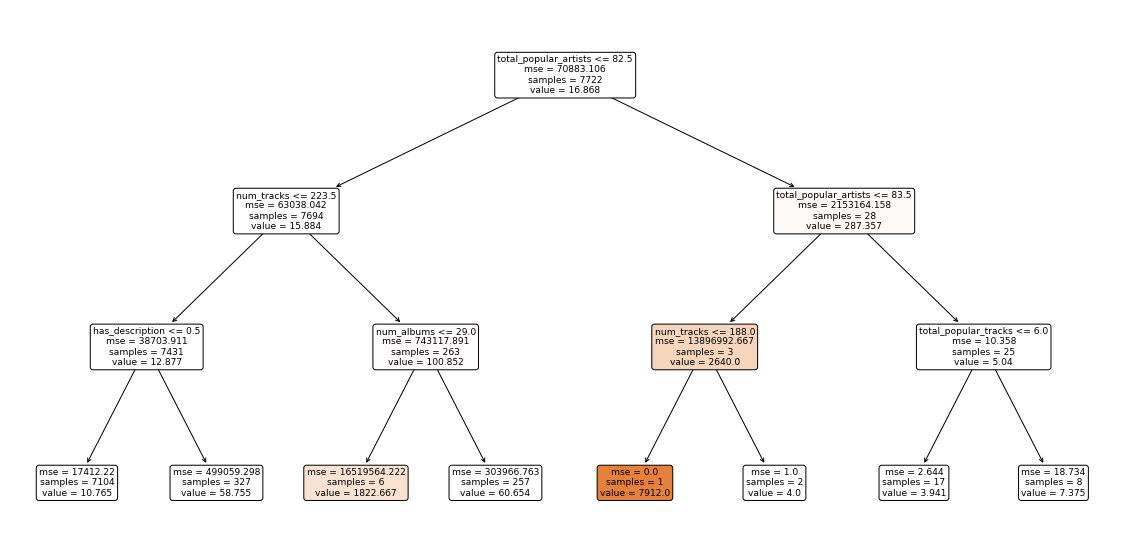

In [44]:
# Initialize a Decision Tree Regressor of depth 3 
baseline_dtree = DecisionTreeRegressor(max_depth = 3, random_state = 109)

# Fit the classifier on the train data
print(f"Model Predictors: {list(X_train.columns)}\n")
baseline_dtree.fit(X_train, y_train)
y_train_pred_dtr = baseline_dtree.predict(X_train)
y_test_pred_dtr = baseline_dtree.predict(X_test)

train_mse_dtr = mean_squared_error(y_train, y_train_pred_dtr)
test_mse_dtr = mean_squared_error(y_test, y_test_pred_dtr)
train_r2_dtr = r2_score(y_train, y_train_pred_dtr)
test_r2_dtr = r2_score(y_test, y_test_pred_dtr)
print(f"Training MSE: {train_mse_dtr:.2f} and Test MSE: {test_mse_dtr:.2f}")
print(f"Training R2: {train_r2_dtr:.2f} and Test R2: {test_r2_dtr:.2f}")

# Save MSEs to dict
model_mses["DecisionTreeRegressor"] = [train_mse_dtr, test_mse_dtr]
model_r2s["DecisionTreeRegressor"] = [train_r2_dtr, test_r2_dtr]

# Plot the Decision Tree trained above 
plt.figure(figsize = (20, 10))
tree.plot_tree(baseline_dtree, filled = True, rounded = True, feature_names = list(X_train.columns))
plt.show()

Motivation:

The motivation behind this baseline model was to use a simple, interpretable form of regression. We chose to use a `DecisionTreeRegressor` with a `max_depth` of 3, and the mean-squared error as our loss function.

When building this baseline model, we knew that the predictive quality would be fairly weak, but at this stage we just wanted to get a general idea of what the predictors are that drive the branches in the tree (and the variability in the outcome).

### Linear Regression

In [45]:
# Initialize and fit a Linear Regression model using Sklearn
linearmodel = LinearRegression()
linearmodel.fit(X_train, y_train)

y_train_pred_linear = linearmodel.predict(X_train)
y_test_pred_linear = linearmodel.predict(X_test)

# compute MSE
train_mse_linear = mean_squared_error(y_train, y_train_pred_linear)
test_mse_linear = mean_squared_error(y_test, y_test_pred_linear)

train_r2_linear = r2_score(y_train, y_train_pred_linear)
test_r2_linear = r2_score(y_test, y_test_pred_linear)

# update dictionaries
model_mses["LinearRegression"] = [train_mse_linear, test_mse_linear]
model_r2s["LinearRegression"] = [train_r2_linear, test_r2_linear]

print(f"Training MSE: {train_mse_linear:.2f} and Test MSE: {test_mse_linear:.2f}")
print(f"Training R2: {train_r2_linear:.4f} and Test R2: {test_r2_linear:.4f} \n")

# look at coefficients
print("Linear Regression coefficients:")
linear_coefs = linearmodel.coef_
for i in range(len(linear_coefs)):
    print(f"   - {X_train.columns[i]}: {linear_coefs[i]:.2f}")
    

Training MSE: 70424.98 and Test MSE: 92976.60
Training R2: 0.0065 and Test R2: -0.0029 

Linear Regression coefficients:
   - popular_name: 9.32
   - has_description: 54.81
   - num_artists: 0.53
   - num_albums: -1.19
   - num_tracks: 0.54
   - duration_ms: 0.00
   - collaborative: -9.40
   - total_popular_tracks: -3.19
   - total_popular_artists: 0.64


Motivation:

A simple linear regression will tell us whether there is a relationship between our predictor variables and the outcome variable, and if there is, what the strength of this relationshp is. We immediately notice that `num_tracks` has approximately no impact on the outcome variable, whereas the `has_description` variable has a very high impact on it. There are also only two variables which have negative coefficients, namely whether the playlist `is_collaborative` and the `total_popular_tracks`. 

### Linear Regression with Cross Validation

In [46]:
# Initialize and fit a Linear Regression model using Sklearn
linearmodelCV = LinearRegression()

# compute MSE
train_mse_linearCV = -1*cross_val_score(linearmodelCV,X_train,y_train,scoring="neg_mean_squared_error", cv=10).mean()
test_mse_linearCV = -1*cross_val_score(linearmodelCV,X_test,y_test,scoring="neg_mean_squared_error", cv=10).mean()

train_r2_linearCV = cross_val_score(linearmodelCV,X_train,y_train,scoring="r2", cv=10).mean()
test_r2_linearCV = cross_val_score(linearmodelCV,X_test,y_test,scoring="r2", cv=10).mean()

# update dictionaries
# note: updating the r2 values with the same as from the simple linear model
model_mses["LinearRegressionCV"] = [train_mse_linearCV, test_mse_linearCV]
model_r2s["LinearRegressionCV"] = [train_r2_linearCV, test_r2_linearCV]

# print(train_mse_linearCV)
print(f"Training crossval MSE: {train_mse_linearCV:.2f} and crossval Test MSE: {test_mse_linearCV:.2f}")
print(f"Training R2: {train_r2_linearCV:.4f} and Test R2: {test_r2_linearCV:.4f}")

Training crossval MSE: 71070.47 and crossval Test MSE: 93065.69
Training R2: -0.1940 and Test R2: -0.6651


Motivation:

By performing ten-fold cross validation, we address the potential problem of overfitting on the training set that we could have encountered when simply training a linear regression model on one training set and evaluating on one test set. Here, we notice that the cross validation scores for both the training and test sets are roughly the same as they were above. 

### Bagging Regressor

In [47]:
# want to fit a bagging regressor at the optimal number of bootstraps
# need to fine-tune the maximum depth and number of bootstraps
bootstraps = np.arange(1, 50, 10)
depths = np.arange(1, 20, 2)

# will need to split my train set into a train and validation set, so I will do that here & use 
# this same train/validation for fine-tuning the boosting model
X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(X_train, y_train, train_size=0.8, random_state=109)

# storing test MSEs in a list
nboots_list = []
depth_list = []
bagging_mse_list = []

# loop through these lists
for num_bootstraps in bootstraps:
    for max_depth in depths:

        # define the Bagging Regressor Model
        # using a Decision Tree as my base estimator with depth as mentioned in max_depth
        # & initializing the number of estimators using the num_bootstraps value
        bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth), 
                                   n_estimators=num_bootstraps, random_state=109)                       

        # fitting the model on the train data
        bagging.fit(X_train_cv, y_train_cv)
        y_val_pred_bagging = bagging.predict(X_val_cv)

        # compute MSE & will reference these lists to get the fine-tuned hyperparameters
        bagging_mse_list.append(mean_squared_error(y_val_cv, y_val_pred_bagging))
        nboots_list.append(num_bootstraps)
        depth_list.append(max_depth)

In [48]:
# getting the fine-tuned hyperparameters based on the above loop
best_idx = bagging_mse_list.index(min(bagging_mse_list))
best_boots = nboots_list[best_idx]
best_depth = depth_list[best_idx]
print(f"Bagging Best Depth: {best_depth}")

# setting our depth and number of bootstraps accordingly
max_depth = best_depth
num_bootstraps = best_boots

# define the Bagging Regressor Model
# using a Decision Tree as my base estimator with depth as mentioned in max_depth
# & initializing the number of estimators using the num_bootstraps value
bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth), n_estimators=num_bootstraps, 
                          random_state=109)

# fitting the model on the entire train dataset
bagging.fit(X_train, y_train)

# getting predictions to calculate MSEs
y_test_pred_bagging = bagging.predict(X_test)
y_train_pred_bagging = bagging.predict(X_train)

# compute MSE
train_mse_bagging = mean_squared_error(y_train, y_train_pred_bagging)
test_mse_bagging = mean_squared_error(y_test, y_test_pred_bagging)

# computing r2
train_r2_bagging = r2_score(y_train, y_train_pred_bagging)
test_r2_bagging = r2_score(y_test, y_test_pred_bagging)

# update dictionaries
model_mses["BaggingRegression"] = [train_mse_bagging, test_mse_bagging]
model_r2s["BaggingRegression"] = [train_r2_bagging, test_r2_bagging]

# printing results
print(f"Training MSE: {np.around(train_mse_bagging, 2)} and Test MSE: {test_mse_bagging:.2f}")
print(f"Training R2: {train_r2_bagging:.4f} and Test R2: {test_r2_bagging:.4f} \n")

Bagging Best Depth: 1
Training MSE: 70409.71 and Test MSE: 93023.64
Training R2: 0.0067 and Test R2: -0.0034 



Motivation:

A bagging regressor fits many relatively complex decision trees and  returns the average of each tree's outputs. This approach allows for high expressiveness in that each of the deep trees can approximate complex functions and decision boundaries. However, it also maintains a low variance since averaging the predictions across all models will reduce the variance in the final prediction. In the context of this dataset, each of our deep trees will consider the many variables used as predictors. However, averaging will help to reduce the impact of overfitting our training set.

While bagging has benefits for prediction, it does lose much of the interpretability offered by a linear regression. Linear regressions allows one to examine which terms have the largest and most significant association with the follower count of a playlist. Bagging, on the other hand, averages many models, so one can no longer trace the logic of the output through a single tree.

Despite its inability to isolate the variables that drive playlist popularity, a bagging model can produce a strong predictive model for a playlist's number of followers. In order to do accomplish this, we first fine-tuned the maximum depth and number of bootstraps with a validation set. After determining which combination of depths and bootstraps minimized the validation MSE, we fit a bagging regressor on the entire train set and recorded its MSE and $R^2$ in the relevant dictionaries. We see that our test MSE is slightly higher for this bagging regressor than it was for our linear regression with cross-validation.

### Gradient Boosting Regressor

In [49]:
# fine-tuning hyperparameters... only doing shallow depths since 
# boosting uses simple trees
l_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
depths = [1, 2]
estimators = [100, 500, 1000, 1500]

# empty lists to keep track of everything
boosting_mse_list = []
depth_list = []
n_estimators_list = []
l_rate_list = []

for l_rate in l_rates:
    for max_depth in depths:
        for n_estimators in estimators:
            
            # initialize a Boosting model using sklearn's boosting model 
            # Use estimators, depth, and learning rate as defined above
            boosted_model  = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                                       learning_rate = l_rate, random_state=109)

            # fit on the train data
            boosted_model.fit(X_train_cv, y_train_cv)

            # predict on the test data
            y_val_pred_boosted = boosted_model.predict(X_val_cv)
            
            # store MSEs and other values in lists
            boosting_mse_list.append(mean_squared_error(y_val_cv, y_val_pred_boosted))
            depth_list.append(max_depth)
            n_estimators_list.append(n_estimators)
            l_rate_list.append(l_rate)

In [50]:
# getting the fine-tuned hyperparameters based off of the above loop
best_idx = boosting_mse_list.index(min(boosting_mse_list))
best_n_estimators = n_estimators_list[best_idx]
best_depth = depth_list[best_idx]
best_l_rate = l_rate_list[best_idx]

# refitting our model with these fine-tuned hyperparameters
l_rate = best_l_rate
max_depth = best_depth
n_estimators = best_n_estimators

# initialize a Boosting model using sklearn's boosting model 
# use estimators, depth, and learning rate as defined above
boosted_model  = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                           learning_rate = l_rate, random_state=109)

# fit on the entire train data
boosted_model.fit(X_train, y_train)

# getting predictions to calculate MSEs
y_test_pred_boosted = boosted_model.predict(X_test)
y_train_pred_boosted = boosted_model.predict(X_train)

# compute MSE
train_mse_boosted = mean_squared_error(y_train, y_train_pred_boosted)
test_mse_boosted = mean_squared_error(y_test, y_test_pred_boosted)

# computing r2
train_r2_boosted = r2_score(y_train, y_train_pred_boosted)
test_r2_boosted = r2_score(y_test, y_test_pred_boosted)

# update dictionaries
model_mses["BoostingRegressor"] = [train_mse_boosted, test_mse_boosted]
model_r2s["BoostingRegressor"] = [train_r2_boosted, test_r2_boosted]

# printing results
print(f"Training MSE: {np.around(train_mse_boosted, 2)} and Test MSE: {test_mse_boosted:.2f}")
print(f"Training R2: {train_r2_boosted:.4f} and Test R2: {test_r2_boosted:.4f} \n")

Training MSE: 70796.53 and Test MSE: 92724.31
Training R2: 0.0012 and Test R2: -0.0002 



Motivation:

Boosting improves decision trees in a way different from a bagging approach; while bagging decreases the variance of complex trees, boosting decreases the bias of simple trees. Essentially, boosting additively combines an ensemble of shallow trees into a single, more complex model. More specifically, a gradient boosting regressor will iteratively add simple models that compensate for the weaknesses of the current ensemble.

Once again, we fine-tuned our hyperparameters on a validation set. Once determining the proper parameters, we fit our gradient boosting regressor on the entire training dataset. Our gradient boosting regressor has the lowest test MSE of all of the above models, indicating that our dataset benefited from its expressive abilities.

## Model Assessment

In [51]:
# compare model mses's and R2 scores
mse_results = pd.DataFrame.from_dict(model_mses, orient='index', columns=["train", "test"])
r2_results = pd.DataFrame.from_dict(model_r2s, orient='index', columns=["train", "test"])

print("Mean Squared Error Results:")
display(mse_results)
print("\nR2 Results:")
display(r2_results)

Mean Squared Error Results:


,train,test
DecisionTreeRegressor,60104.356338,92953.198955
LinearRegression,70424.983482,92976.603174
LinearRegressionCV,71070.471543,93065.692295
BaggingRegression,70409.712791,93023.635883
BoostingRegressor,70796.534384,92724.305320



R2 Results:


,train,test
DecisionTreeRegressor,0.152064,-0.002685
LinearRegression,0.006463,-0.002938
LinearRegressionCV,-0.194040,-0.665072
BaggingRegression,0.006679,-0.003445
BoostingRegressor,0.001221,-0.000216


**Interpretation**

Based on the two dataframes above, the `BoostingRegressor` reported the lowest MSE on the test set. The R2 values were all negative on the test set, indicating that our model fitting was no more successful than predicting the mean `num_followers` as the true `num_followers` for each playlist.

As a result, out of the options above, the `BoostingRegressor` is the "best" model because it resulted in the lowest MSE.

The reason why our models could have performed so poorly is due to the disparity between what made a playlist popular or not. Out of the one million playlists in the dataset, only 0.003% (< 3000) had 20 or more followers (our threshold for 'popular'). This number might have been even smaller during our training and testing of our models, leading to our models not being able to find a trend to discern playlist features that affect popularity.

## Conclusion

**Strengths:** Our project approach is strong in that our dataset is clean and easily understandable. We also have a lot of observations to work with, which should theoretically allow for us to uncover trends. In addition, since we did not perform PCA or any transformations on the data, our results are highly interpretable.

**Limitations:** The main limitation of our project approach is that our model predictions are not strong. The MSE values are still relatively high, and the R2 values indicate that our predictions are no better than predicting the mean `num_followers` for each observation. This, of course, is a significant drawback, as our goal is to be able to effectively predict the number of followers for each playlist. The dataset also did not have a normal distribution of popular and not popular playlists, with less than 1% of all one million playlists being popular. For this reason, our model might not have had sufficient information to begin with in order to accurately predict the number of followers.

**Possible Future Work:** One way in which we can improve our approach is to successfully query the Spotify API and add more interesting variables (such as song/playlist sentiment) to our data frame. Specifically, the audio features and audio analysis (tempo, time song fades in, duration of song, etc.) we can get from the API can greatly inform our model and predictions. With more and more playlists being themed, it is hard to ignore that the types of songs in a playlist can also affect popularity. Would playlists with mostly fast, happy, danceable songs be more popular than playlists with slow, sad, chill songs? The inclusion of these predictors may result in more meaningful predictions if these new variables help explain the variance in the outcome. 

### Spotify API Demo
Below we provide a demo of using the spotify API to extract audio features from a playlist. We limit our sample to 50 to keep the loading time brief, and perform a little EDA to show how future projects can begin implementing the API into their research





In [25]:
# credentials
SPOTIPY_CLIENT_ID = '420fbc1257c94c6e837c7228adb7ddea'
SPOTIPY_CLIENT_SECRET = '3c78b2c41dc44a4f95289c2be60114b3'

# Extract small sample of 50 playlists
demo_sample = playlist_data_sample.sample(50, random_state=109, ignore_index=True)

# Get playlist information
playlists = demo_sample['tracks']

# Return features of playlists into dataframe 
demo = spotify_demo(playlists, SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET)

Looking at the distribution of the average danceability, energy, and valence in the playlists. 

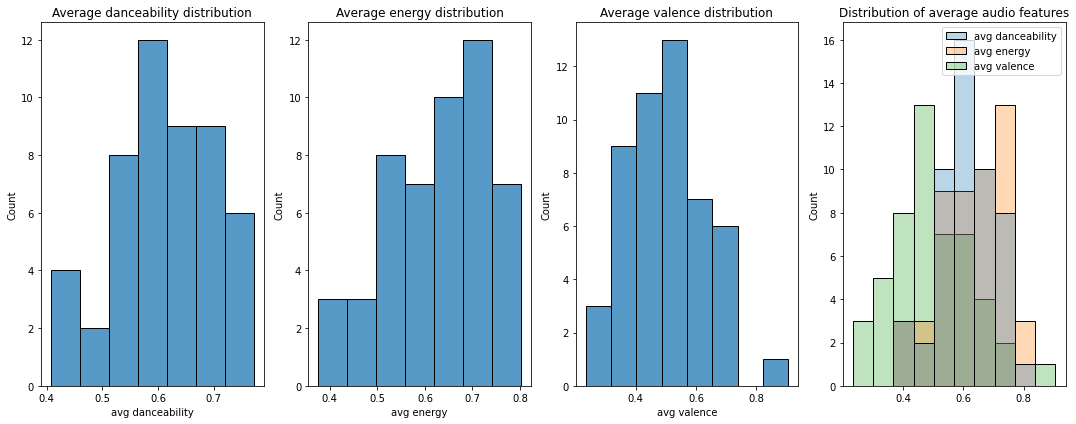

In [26]:
# extract info
features = demo.columns[:3]
avgs = demo.columns[3:]

# Plotting distribution of audio features
fig, ax = plt.subplots(1,4, figsize=(15,6))

for i in range(3, 6):
    sns.histplot(demo.iloc[:, i], ax=ax[i-3])
    ax[i-3].set_title(f'Average {features[i-3]} distribution')

sns.histplot(demo.iloc[:, 3:], ax=ax[3], alpha=0.3)
ax[3].set_title('Distribution of average audio features')

plt.tight_layout()

Looking at the total audio features of interest as well as the average audio features of interest per playlist.

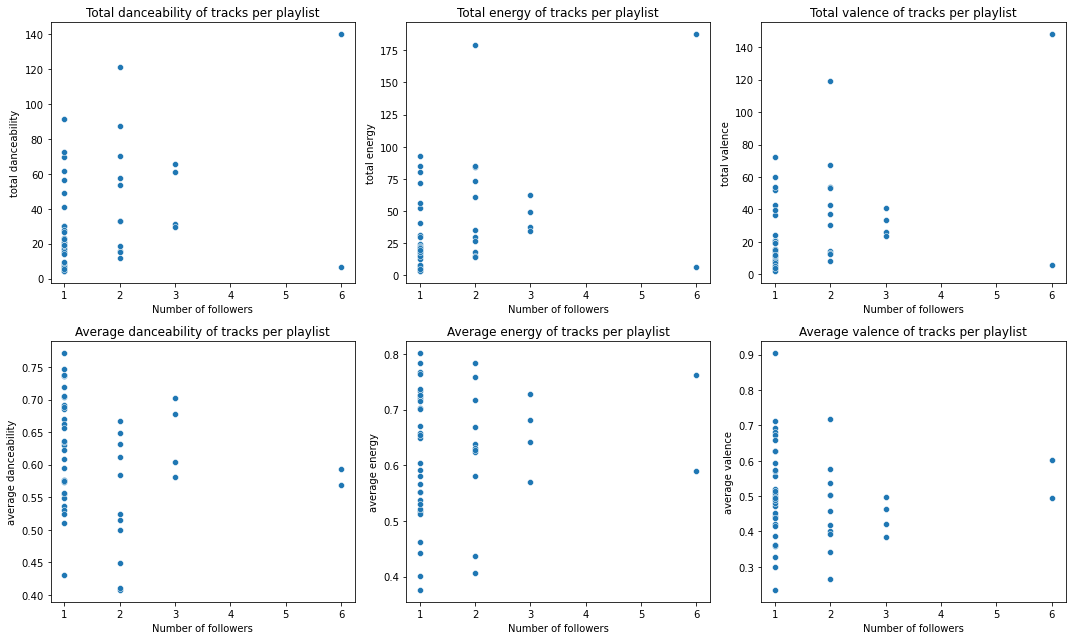

In [27]:
playlist_demo = pd.concat([demo_sample, demo], axis=1)

fig, ax = plt.subplots(2,3, figsize=(15,9))

for i in range(3):
    sns.scatterplot(data=playlist_demo, y=features[i], x='num_followers', ax=ax[0,i])
    ax[0,i].set_xlabel('Number of followers')
    ax[0,i].set_ylabel(f'total {features[i]}')
    ax[0,i].set_title(f'Total {features[i]} of tracks per playlist')
    sns.scatterplot(data=playlist_demo, y=avgs[i], x='num_followers', ax=ax[1,i])
    ax[1,i].set_xlabel('Number of followers')
    ax[1,i].set_ylabel(f'average {features[i]}')
    ax[1,i].set_title(f'Average {features[i]} of tracks per playlist')

plt.tight_layout()

Just by briefly looking at the plots, you can see that most playlists in our sample tend to have a more danceable and energetic tracks and less happy sounding tracks. Although there is not a clear trend that can be discerned for the audio features and the number of followers, there seems to be a connection between the average energy of the tracks in a playlist and its popularity. 

Future works can increase the sample size to see if these initial observations hold in larger datasets, and whether a pattern (or lack thereof) is apparent between the audio features and a playlist's popularity.